# Image Colorization Using Auto Encoder

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio

In [2]:
# Load CIFAR-10 dataset
(X_train, _), (X_test, _) = keras.datasets.cifar10.load_data()
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
X_train shape is  (50000, 32, 32, 3)
X_test shape is  (10000, 32, 32, 3)


In [3]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [4]:
X_train_gray = np.dot(X_train[..., :3], [0.2989, 0.5870, 0.1140])
X_test_gray = np.dot(X_test[..., :3], [0.2989, 0.5870, 0.1140])
print('X_train_gray shape is ' , X_train_gray.shape)
print('X_test_gray shape is ' , X_test_gray.shape)

X_train_gray shape is  (50000, 32, 32)
X_test_gray shape is  (10000, 32, 32)


In [5]:
X_train_gray = np.expand_dims(X_train_gray, axis=-1)
X_test_gray = np.expand_dims(X_test_gray, axis=-1)
print('X_train_gray shape is ' , X_train_gray.shape)
print('X_test_gray shape is ' , X_test_gray.shape)

X_train_gray shape is  (50000, 32, 32, 1)
X_test_gray shape is  (10000, 32, 32, 1)


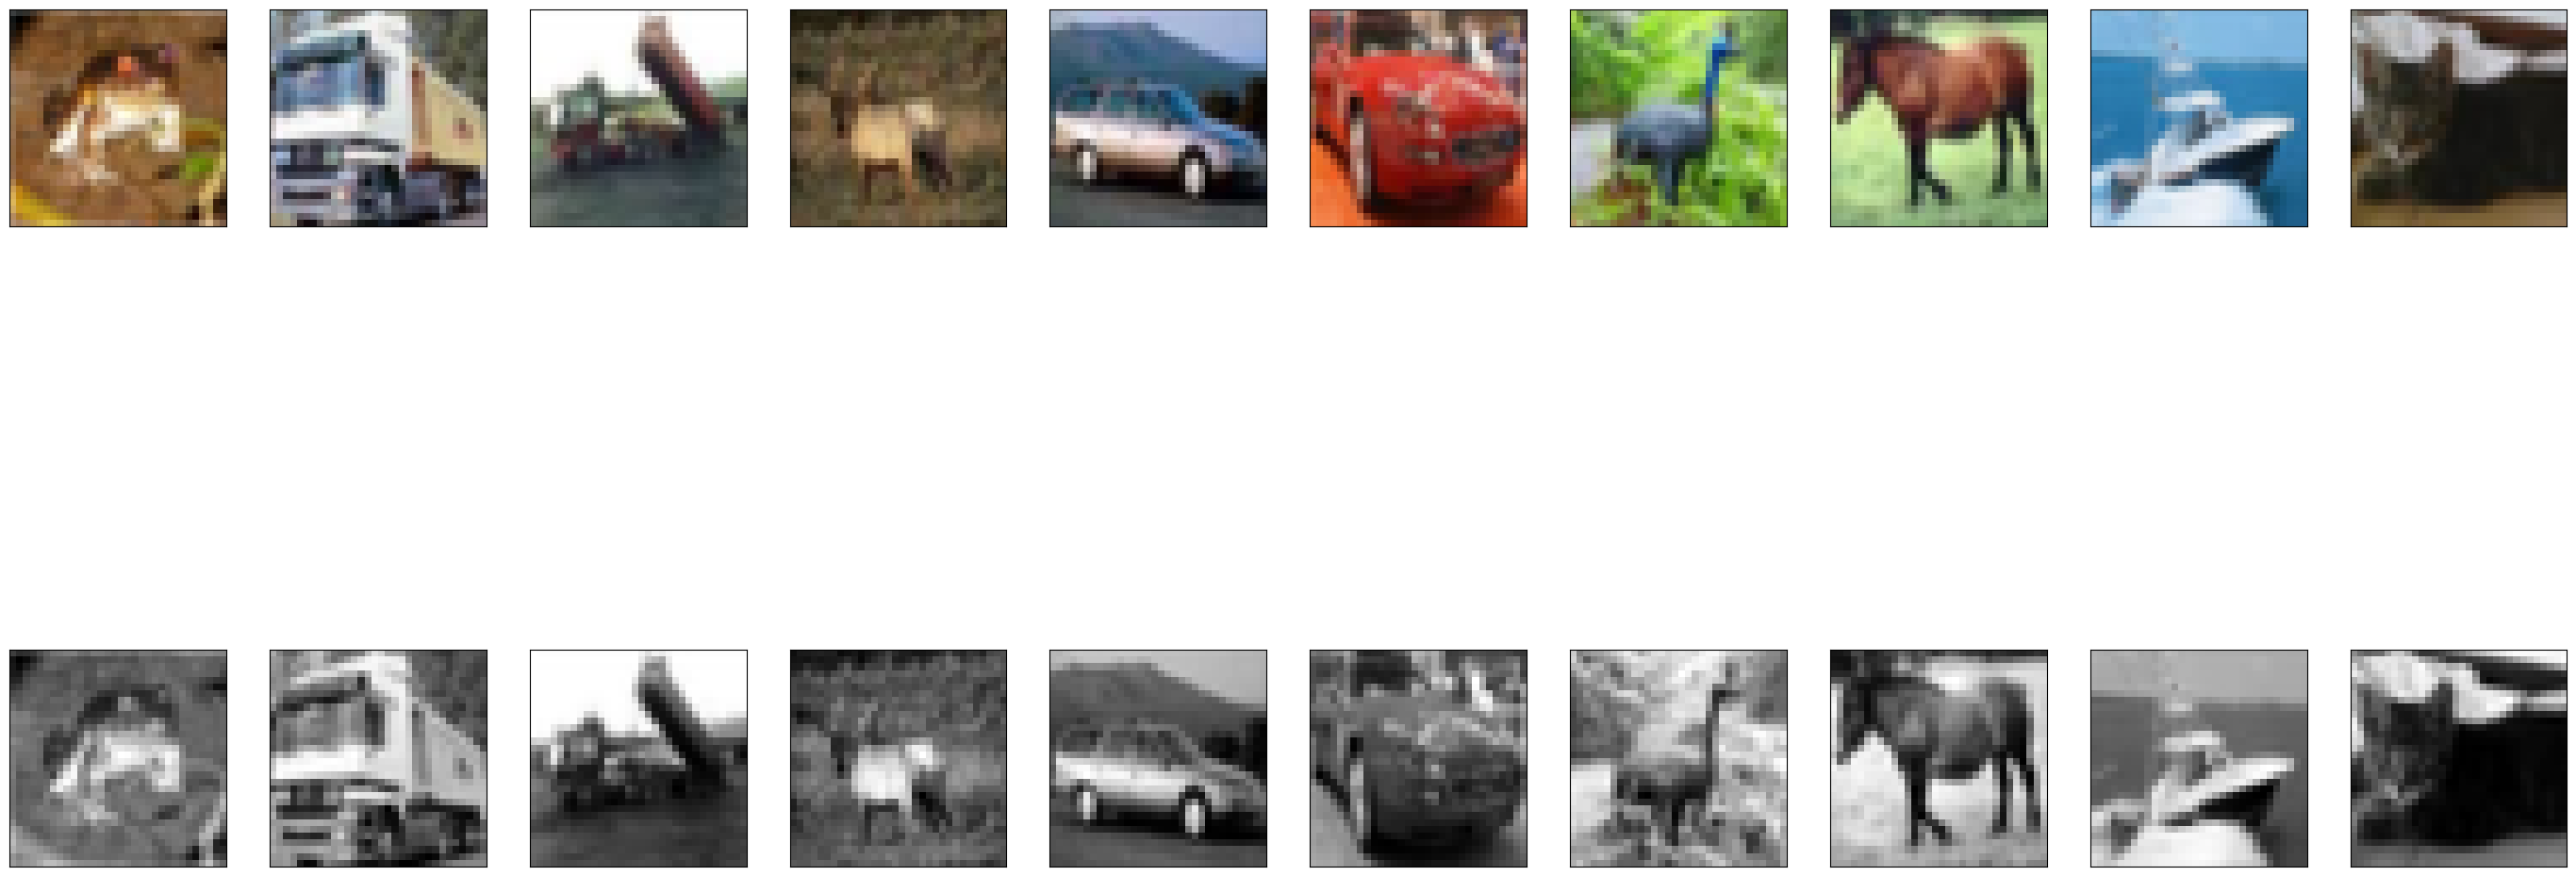

In [6]:
n=10
plt.figure(figsize=(35,25))
for i in range(n):
    # Display color images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_train[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display black images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(X_train_gray[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

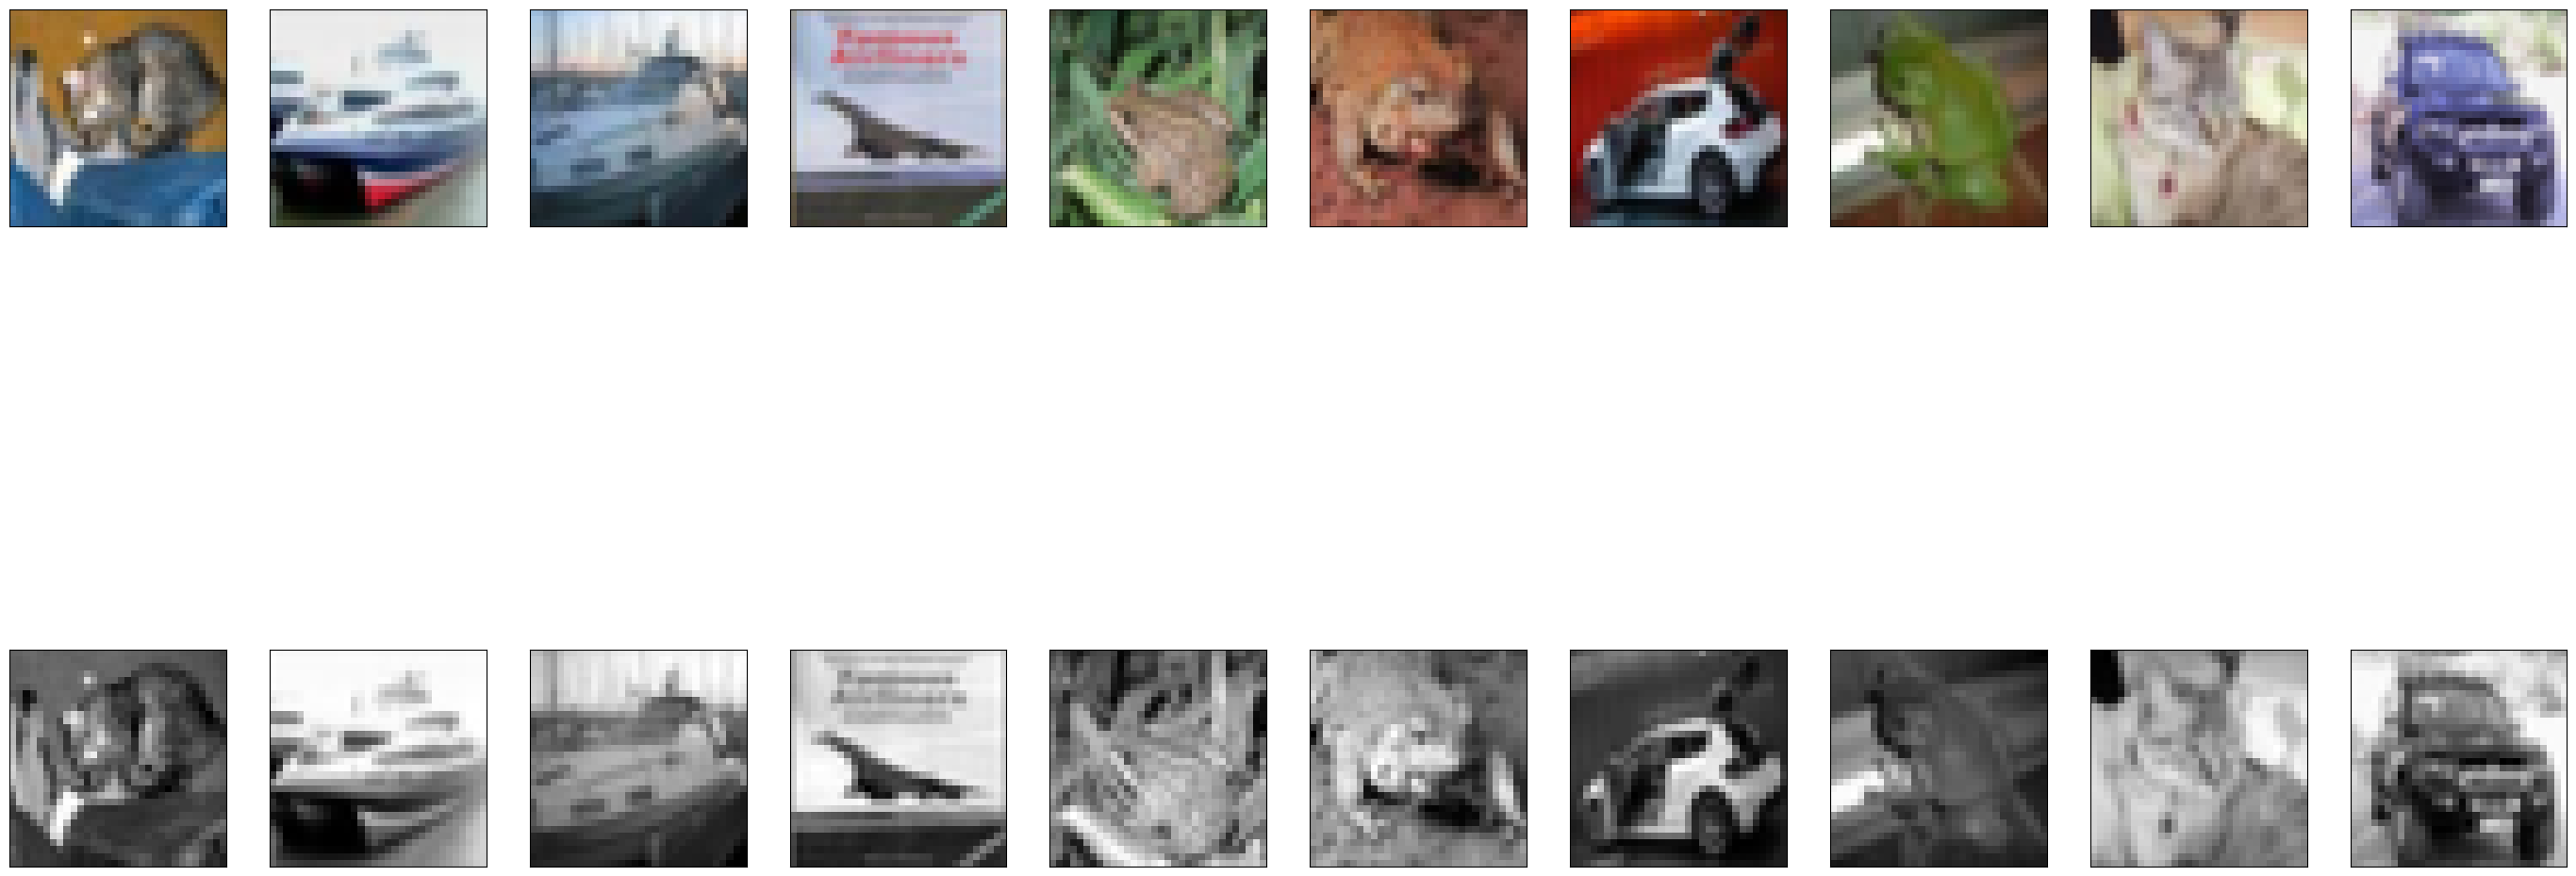

In [7]:
n=10
plt.figure(figsize=(35,25))
for i in range(n):
    # Display color images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display black images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(X_test_gray[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 8, 8, 64)  │          0 │ max_pooling2d_1[… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │     18,464 │ up_sampling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 150,211 (586.76 KB)

 Trainable params: 149,571 (584.26 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/100


I0000 00:00:1731846898.629007     104 service.cc:145] XLA service 0x7f7820002280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731846898.629061     104 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731846898.629065     104 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  38/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3708 - mae: 0.4518  

I0000 00:00:1731846902.958608     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0525 - mae: 0.1352 - val_loss: 0.0100 - val_mae: 0.0719 - learning_rate: 0.0010
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0102 - mae: 0.0743 - val_loss: 0.0100 - val_mae: 0.0676 - learning_rate: 0.0010
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0090 - mae: 0.0693 - val_loss: 0.0079 - val_mae: 0.0636 - learning_rate: 0.0010
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0086 - mae: 0.0673 - val_loss: 0.0180 - val_mae: 0.0868 - learning_rate: 0.0010
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0090 - mae: 0.0693 - val_loss: 0.0086 - val_mae: 0.0674 - learning_rate: 0.0010
Epoch 6/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0080 - mae: 0.0648 - val_loss: 0.0073 - val_mae: 0.0613 - learning_rate: 0.0010
Epoch 7/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0079 - mae: 0.0644 - val_loss: 0.0078 - val_mae: 0.0626 - learning_rate: 0.0

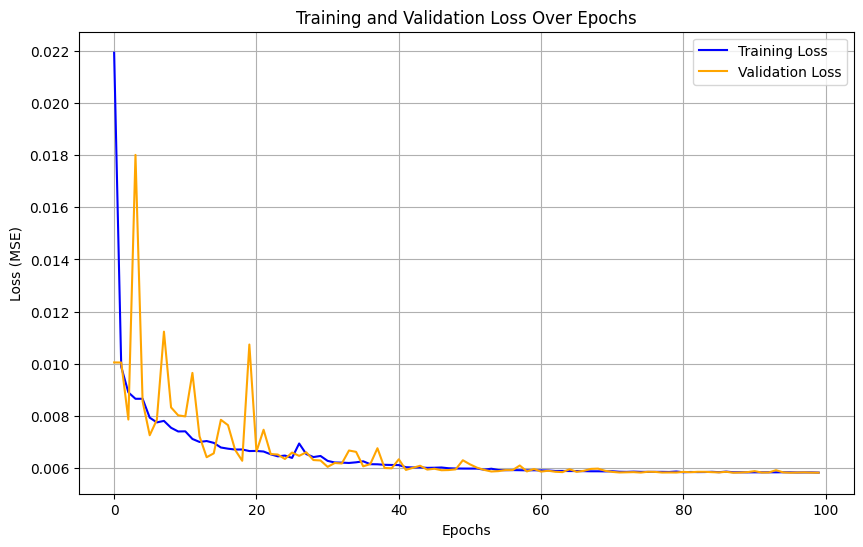

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Add
import matplotlib.pyplot as plt

# Function to add a residual connection
def residual_block(x, filters, kernel_size=3):
    res = Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    res = BatchNormalization()(res)
    res = Conv2D(filters, kernel_size, padding='same', activation='relu')(res)
    res = BatchNormalization()(res)
    return Add()([x, res])

# Input layer with shape (32, 32, 1)
input_ = keras.layers.Input(shape=(32, 32, 1))

# Encoder
x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
encoder = MaxPooling2D((2, 2), padding='same')(x)

# Residual Block to enhance feature extraction
encoder = residual_block(encoder, 64)

# Decoder
x = Conv2D(64, (3, 3), padding='same', activation='relu')(encoder)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)

# Adjust the output layer for an RGB image (3 channels)
decoder = Conv2D(3, (3, 3), padding='same', activation='tanh')(x)

# Autoencoder model
autoencoder = keras.models.Model(inputs=input_, outputs=decoder)
autoencoder.summary()

# Compile the model with Mean Squared Error loss
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Define callbacks for saving best model and early stopping
checkpoint_cb = keras.callbacks.ModelCheckpoint("colorization_model.keras", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=10, min_lr=1e-5)

# Train the model
history = autoencoder.fit(
    X_train_gray, X_train,  # Assuming X_train_gray (grayscale), X_train (color)
    epochs=100,
    batch_size=32,
    validation_data=(X_test_gray, X_test),
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

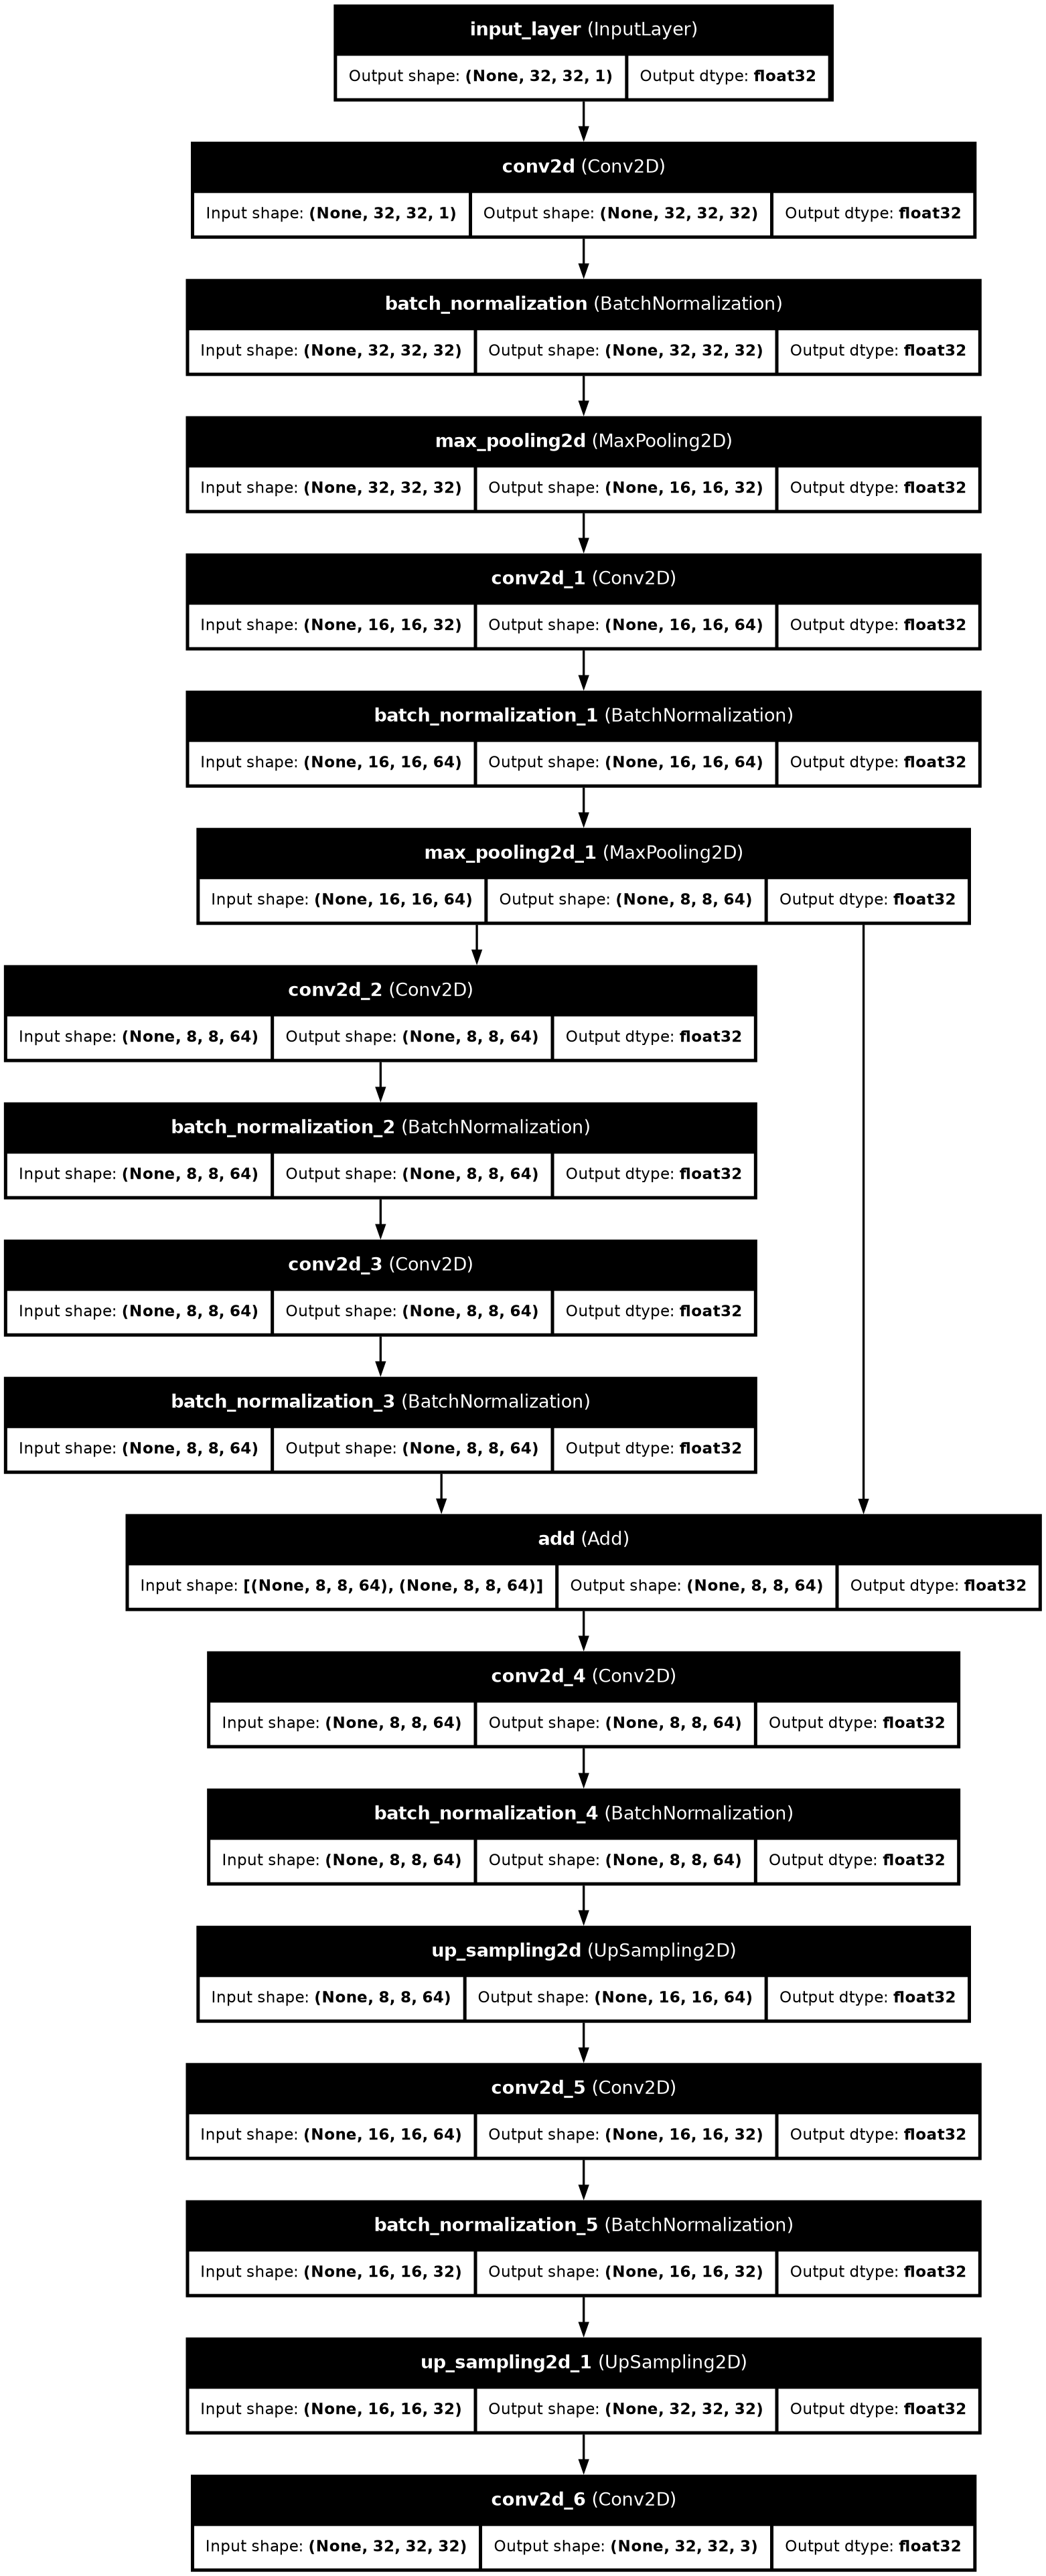

In [9]:
tf.keras.utils.plot_model(autoencoder, to_file='model2.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [15]:
#checkpoint_cb =ModelCheckpoint("autoencoder.keras",save_best_only=True)
#autoencoder.compile(optimizer ='adam', loss='mse')
#hist=autoencoder.fit(X_train_gray,X_train,epochs=200,validation_data=(X_test_gray,X_test),callbacks=[checkpoint_cb])

In [16]:
#hist_=pd.DataFrame(hist.history)
#hist_

In [11]:
autoencoder.evaluate(X_test_gray,X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0059 - mae: 0.0527


[0.005819873418658972, 0.05243019387125969]

In [12]:
predictions = autoencoder.predict(X_test_gray)
predictions.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


(10000, 32, 32, 3)

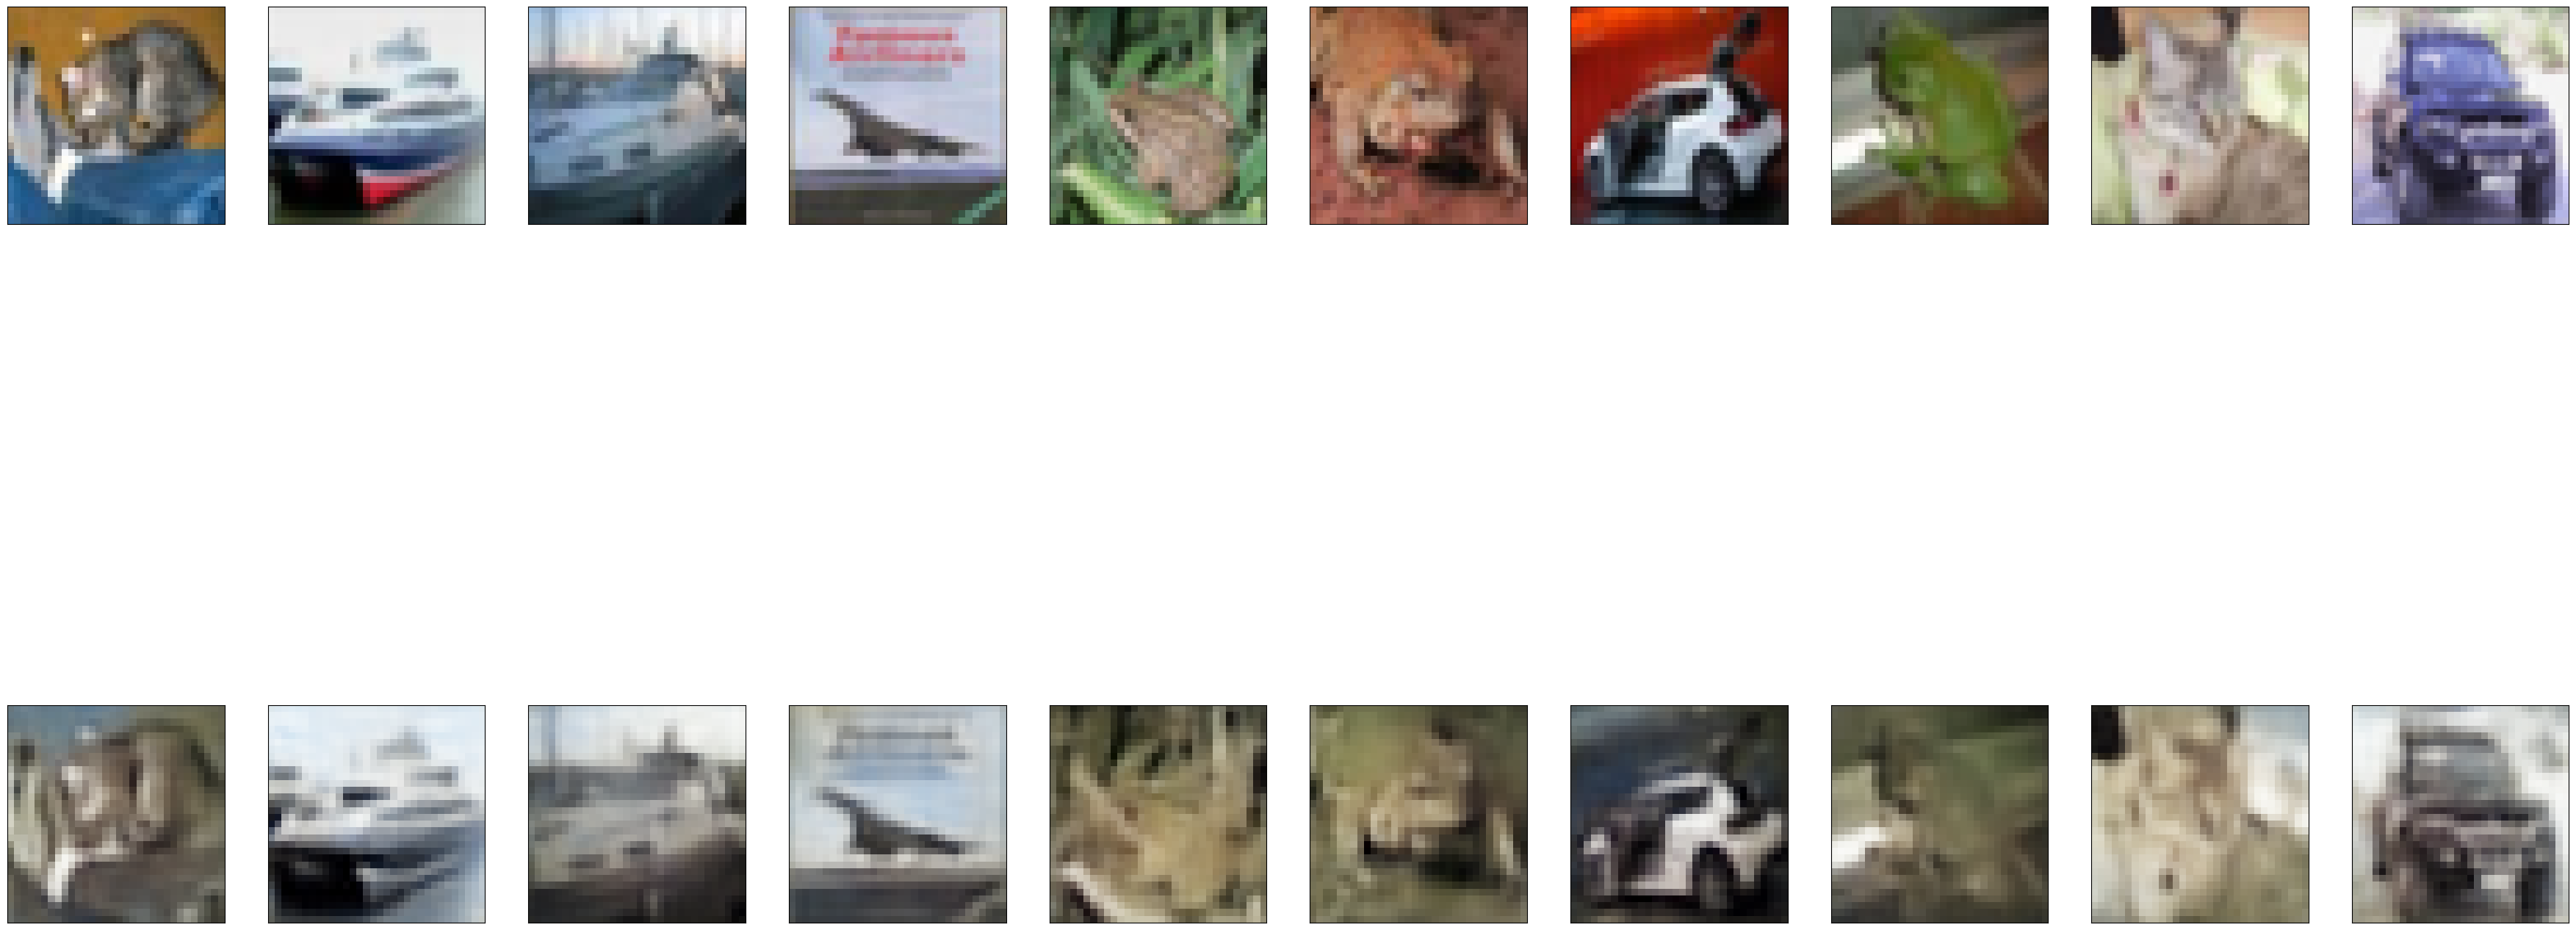

In [13]:
n=10
plt.figure(figsize=(45,35))
for i in range(n):
    # Display color images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display black images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(predictions[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [14]:
psnr_values=[abs(peak_signal_noise_ratio(color,pred,data_range=color.max()-pred.min())) 
             for color,pred in zip(X_test,predictions)]
print('Average PSNR =',np.mean(psnr_values))

Average PSNR = 22.661149744934093
